In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

Init Plugin
Init Graph Optimizer
Init Kernel


In [12]:
import numpy as np
import os
import math
import matplotlib.pyplot as plt
from keras.applications import vgg16
from PIL import Image

In [54]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
BATCH = 64
IMG_SIZE = 150

In [4]:
train_path = os.getcwd()+'/cats and dogs/training_set'
test_path = os.getcwd() + '/cats and dogs/test_set'

In [5]:
def keras_pipeline():
    train_gen = keras.preprocessing.image.ImageDataGenerator(
                                                            rescale= 1./255,
                                                            rotation_range=40,
                                                            width_shift_range=0.2,
                                                            height_shift_range=0.2,
                                                            shear_range=0.2,
                                                            zoom_range=0.2,
                                                            horizontal_flip=True)
    test_gen = keras.preprocessing.image.ImageDataGenerator(rescale=1/255.0)
    
    train_gen = train_gen.flow_from_directory(train_path,target_size=(IMG_SIZE,IMG_SIZE),batch_size=BATCH,class_mode='binary')
    test_gen = test_gen.flow_from_directory(test_path,target_size=(IMG_SIZE,IMG_SIZE),batch_size=BATCH,class_mode='binary')
    return train_gen ,test_gen

In [6]:
per_epoch_stop = math.ceil(8005/BATCH)
per_epoch_stop_val = math.ceil(2023/BATCH)

In [20]:
model = vgg16.VGG16(include_top=False,input_shape=(150,150,3))

In [44]:
layer_name = 'block1_pool'

In [50]:
def get_loss(img,filter_ind,extractor):
    out = extractor(img)
    out = out[:,:,:,filter_ind]
    return tf.reduce_mean(out)

@tf.function
def apply_gradients(img,extractor,filter_ind,lr=5):
    with tf.GradientTape() as tape:
        tape.watch(img)
        loss = get_loss(img,filter_ind,extractor)
        
    grads = tape.gradient(loss,img)
    grads = tf.math.l2_normalize(grads)
    img += grads * lr
    return loss,img

def deprocess(img):
    img -= img.mean()
    img /= img.std() + 1e-5
    img *= 0.15
    
    img += 0.5
    img = np.clip(img,0,1)
    
    img *= 255
    img = np.clip(img,0,255).astype('uint8')
    return img

def get_filter_img(filter_ind,layer):
    
    extractor = keras.Model(inputs=model.inputs,outputs=layer.output)
    random_img = np.random.uniform(size=(1,IMG_SIZE,IMG_SIZE,3))
    random_img = (random_img - 0.5) * 0.25
    
    for i in range(40):
        loss,img = apply_gradients(random_img,extractor,filter_ind,lr=10)
    
    img = deprocess(img[0].numpy())
    return img

def show_filter(layer_name,size):
    filters = model.get_layer(layer_name).output.shape[-1]
    layer = model.get_layer(layer_name)
    source = []
    for each in range(filters):
        source.append(get_filter_img(each,layer))
                      
    show_graphs(filters,source,size)

def show_graphs(total_size,source,size):
    rows = int(total_size / 8)
    fig,ax = plt.subplots(rows,8)
    fig.set_figwidth(size)
    fig.set_figheight(size)
    ind = 0
    for row in range(rows):
        for col in range(8):
            ax[row][col].imshow(source[ind])
            ind+=1
    


In [48]:
def show_filter_output(img,layer_name,filter_index=1):
    if model is None:
        return "Model not initialized !"
    layer = model.get_layer(layer_name)
    extractor = keras.Model(inputs=model.inputs,outputs=layer.output)
    out = extractor.predict(img)
    filters = layer.output.shape[-1]
    activations = extractor.predict(img)
    if(filter_index==-1):
        source  = []
        for each in range(filters):
            source.append(activations[0,:,:,each])
        
        show_graphs(filters,source,20)
    else:
        plt.imshow(activations[0,:,:,filter_index])
    
                            

In [38]:
img = Image.open('cats and dogs/test_set/cats/cat.4001.jpg')
img = img.resize((IMG_SIZE,IMG_SIZE))
img = np.asarray(img)

2021-10-02 09:34:06.364242: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


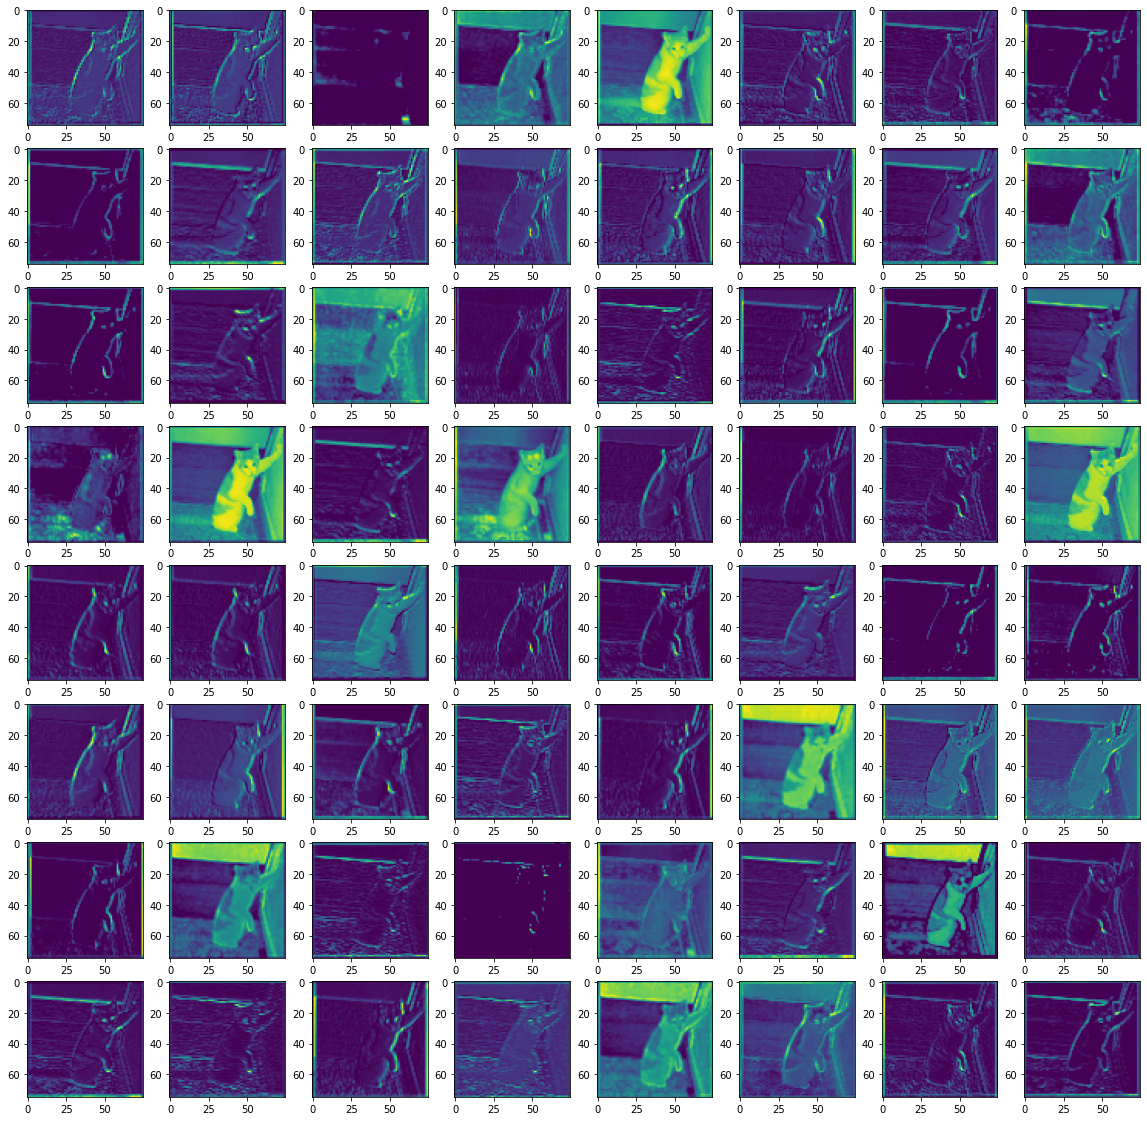

In [46]:
show_filter_output(img[np.newaxis,...],layer_name,filter_index=-1)

2021-10-02 09:41:32.550412: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-10-02 09:41:32.903818: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-10-02 09:41:33.232904: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-10-02 09:41:33.548226: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-10-02 09:41:33.880702: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-10-02 09:41:34.225735: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-10-02 09:41:34.552421: I tensorflow/core/grappler/optimizers/cust

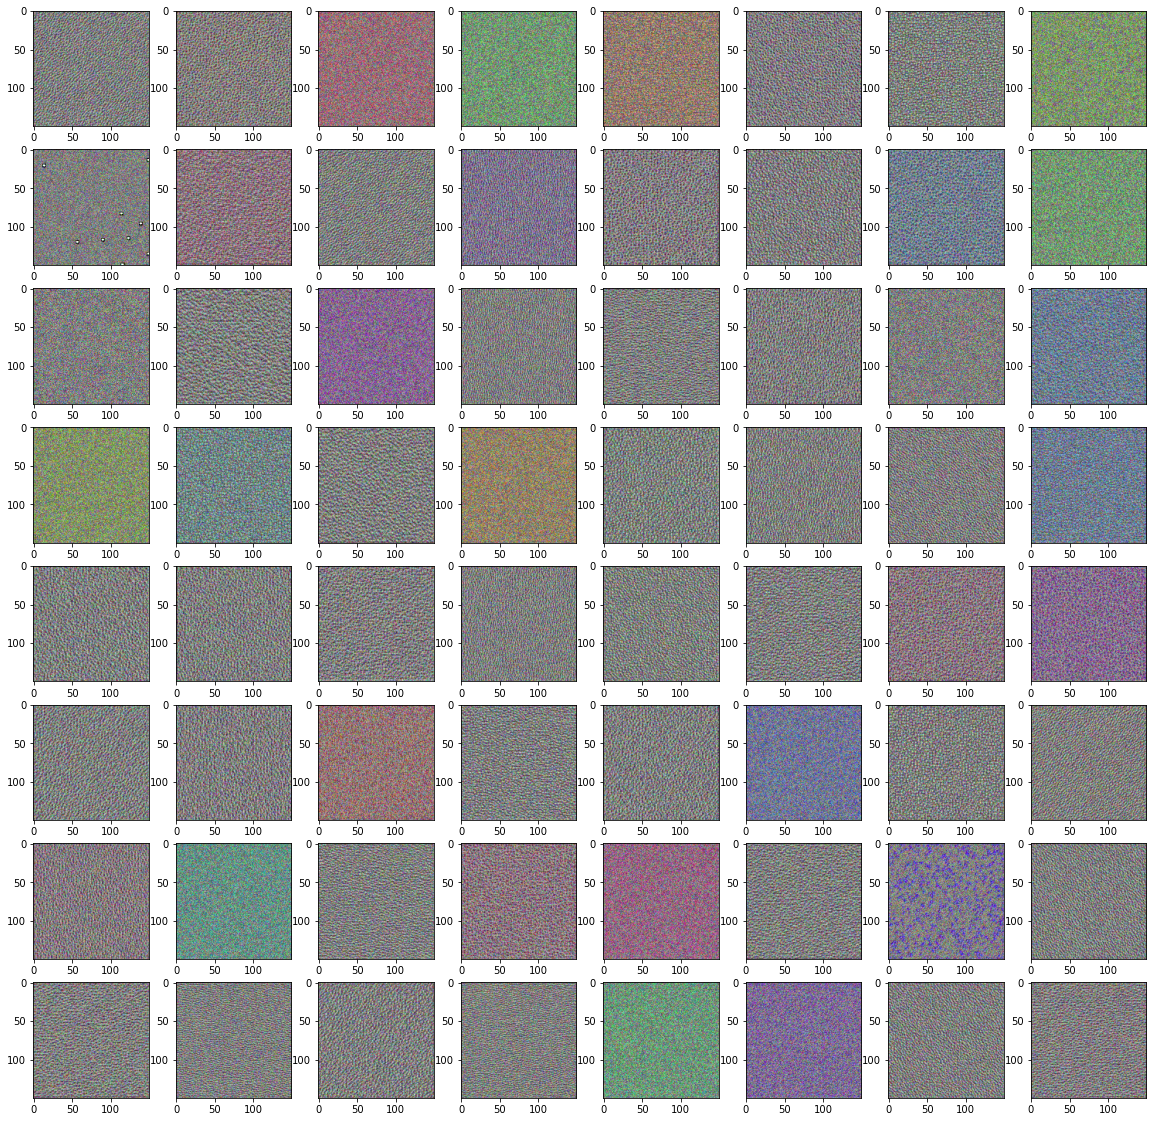

In [56]:
show_filter(layer_name,20)